In [2]:
import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    SplineMagneticField,
    field_line_integrate,
)
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO

# need to specify currents in the coil circuits when using mgrid, just like in VMEC
extcur = [
    3.884526409876309e06,
    -2.935577123737952e05,
    -1.734851853677043e04,
    6.002137016973160e04,
    6.002540940490887e04,
    -1.734993103183817e04,
    -2.935531536308510e05,
    -3.560639108717275e05,
    -6.588434719283084e04,
    -1.154387774712987e04,
    -1.153546510755219e04,
    -6.588300858364606e04,
    -3.560589388468855e05,
]
ext_field = SplineMagneticField.from_mgrid(
    r"/Users/dpanici/Research/DESC/tests/inputs/mgrid_solovev.nc", extcur=extcur
)

pres = PowerSeriesProfile([1.25e-1, 0, -1.25e-1])
iota = PowerSeriesProfile([-4.9e-1, 0, 3.0e-1])
surf = FourierRZToroidalSurface(
    R_lmn=[4.0, 1.0],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[-1.0],
    modes_Z=[[-1, 0]],
    NFP=1,
)

eq_init = Equilibrium(M=10, N=0, Psi=1.0, surface=surf, pressure=pres, iota=iota)
eq_init.solve();

/Users/dpanici/Research/DESC/desc/utils.py:563: UserWarning: mgrid does not appear to contain vector potential information. Vector potential will not be computable.
  warnings.warn(colored(msg, "yellow"), err)


Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 75
Number of objectives: 242

Starting optimization
Using method: lsq-exact
`gtol` condition satisfied. (gtol=1.00e-08)
         Current function value: 5.135e-13
         Total delta_x: 3.499e-01
         Iterations: 38
         Function evaluations: 45
         Jacobian evaluations: 39
                                                                 Start  -->   End
Total (sum of squares):                                      6.012e-02  -->   5.135e-13, 
Maximum absolute Force error:                                8.028e+04  -->   

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 15.6 ms
Timer: Objective build = 48.7 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 30.1 ms
Timer: Objective build = 37.4 ms
Timer: Objective build = 830 us
Timer: Eq Update LinearConstraintProjection build = 35.2 ms
Timer: Proximal projection build = 237 ms
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 54.2 ms
Timer: LinearConstraintProjection build = 67.6 ms
Number of parameters: 5
Number of objectives: 82
Timer: Initializing the optimization = 378 ms

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.145e+00                                    2.498e+00   
       1              2          3.010e-01 

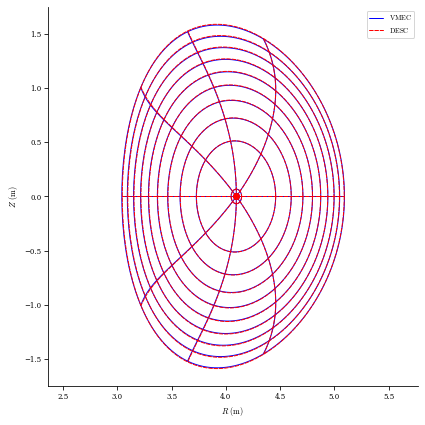

In [29]:
eq2 = eq_init.copy()

constraints = (
    ForceBalance(eq=eq2),
    FixIota(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

# For a standard free boundary solve, we set field_fixed=True. For single stage optimization, we would set to False
objective = ObjectiveFunction(BoundaryError(eq=eq2, field=ext_field, field_fixed=True))

# we know this is a pretty simple shape so we'll only use |m| <= 2
R_modes = eq2.surface.R_basis.modes[np.max(np.abs(eq2.surface.R_basis.modes), 1) > 2, :]
Z_modes = eq2.surface.Z_basis.modes[np.max(np.abs(eq2.surface.Z_basis.modes), 1) > 2, :]
bdry_constraints = (
    FixBoundaryR(eq=eq2, modes=R_modes),
    FixBoundaryZ(eq=eq2, modes=Z_modes),
)
eq2, out = eq2.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,
    options={},
)

VMECIO.plot_vmec_comparison(eq2, "/Users/dpanici/Research/DESC/tests/inputs/wout_solovev_freeb.nc");

In [30]:
eq_freeb_orig = eq2.copy()

# Setup a proximal free bdry test

In [31]:
# here, need ForceBalance and BoundaryError in the constraints
# along with FixPsi and FixIota (let's let pressure be what changes yea)

# what should our objective be? I guess either something like Aspect Ratio or 
# just beta?

# doublethe vol avg beta I guess
p = eq_freeb_orig.pressure.copy()
eq2 = eq_freeb_orig.copy()

orig_beta = eq2.compute(["<beta>_vol"])["<beta>_vol"]
print(orig_beta)
from desc.objectives import GenericObjective
from desc.profiles import ScaledProfile

4.189742955805418e-06


0.004193257227471263
Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 75
Number of objectives: 242

Starting optimization
Using method: lsq-exact
         Current function value: 1.717e-10
         Total delta_x: 1.031e-01
         Iterations: 100
         Function evaluations: 137
         Jacobian evaluations: 101
                                                                 Start  -->   End
Total (sum of squares):                                      2.761e-05  -->   1.717e-10, 
Maximum absolute Force error:                                1.750e+03  -->   1.998e+01 (N)
Minimu

(<Figure size 288.216x360.27 with 1 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

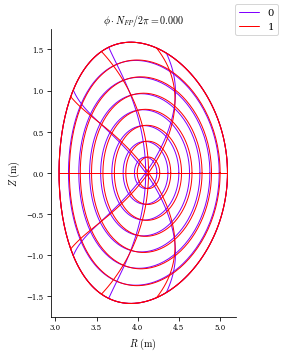

In [36]:
eq2.pressure = ScaledProfile(1e3,p)
print(eq2.compute(["<beta>_vol"])["<beta>_vol"])

eq2.solve(ftol=1e-4)

from desc.plotting import *
plot_comparison([eq_freeb_orig,eq2])

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 15.7 ms
Timer: Objective build = 59.2 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 31.6 ms
Timer: Objective build = 39.2 ms
Timer: Objective build = 924 us
Timer: Eq Update LinearConstraintProjection build = 31.9 ms
Timer: Proximal projection build = 249 ms
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 53.7 ms
Timer: LinearConstraintProjection build = 64.8 ms
Number of parameters: 5
Number of objectives: 82
Timer: Initializing the optimization = 386 ms

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          4.200e-06                                    1.738e-05   
       1              2          4.193e-06 

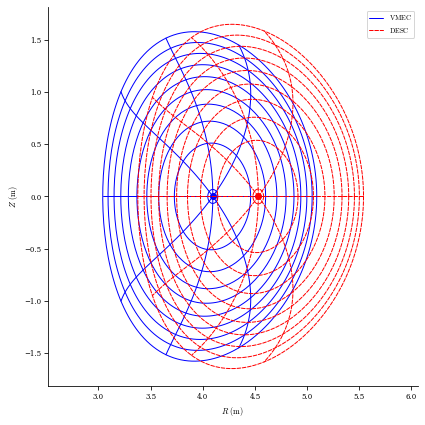

In [38]:
constraints = (
    ForceBalance(eq=eq2),
    FixIota(eq=eq2),
    FixPressure(eq=eq2),
    FixPsi(eq=eq2),
)

# For a standard free boundary solve, we set field_fixed=True. For single stage optimization, we would set to False
objective = ObjectiveFunction(BoundaryError(eq=eq2, field=ext_field, field_fixed=True))

# we know this is a pretty simple shape so we'll only use |m| <= 2
R_modes = eq2.surface.R_basis.modes[np.max(np.abs(eq2.surface.R_basis.modes), 1) > 2, :]
Z_modes = eq2.surface.Z_basis.modes[np.max(np.abs(eq2.surface.Z_basis.modes), 1) > 2, :]
bdry_constraints = (
    FixBoundaryR(eq=eq2, modes=R_modes),
    FixBoundaryZ(eq=eq2, modes=Z_modes),
)
eq2, out = eq2.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,ftol=1e-3,
    options={"solve_options":{"ftol":1e-4,"xtol":1e-7}},
)

VMECIO.plot_vmec_comparison(eq2, "/Users/dpanici/Research/DESC/tests/inputs/wout_solovev_freeb.nc");

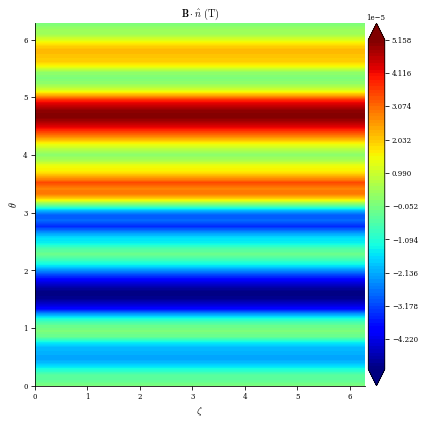

In [39]:
desc.plotting.plot_2d(eq2, "B*n", field=ext_field);

eq_freeb_orig.save("orig_freeb_solovev.h5")
eq2.save("freeb_at_target_beta.h5")

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 281 ms
Timer: Objective build = 308 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 32.2 ms
Timer: Objective build = 41.0 ms
Timer: Objective build = 868 us
Timer: Eq Update LinearConstraintProjection build = 1.71 sec
Timer: Proximal projection build = 2.34 sec
Building objective: fixed iota
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 70.1 ms
Timer: LinearConstraintProjection build = 1.87 sec
Number of parameters: 11
Number of objectives: 123
Timer: Initializing the optimization = 4.32 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          6.649e-06                                    1.792e-03   
       1              7          6.19

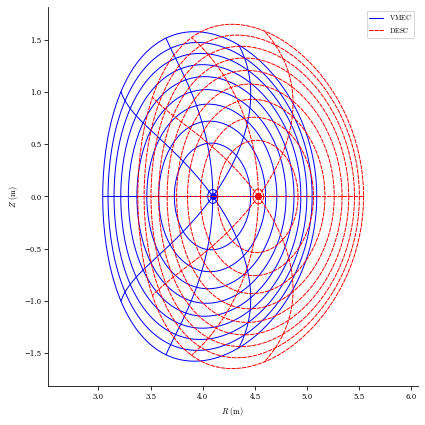

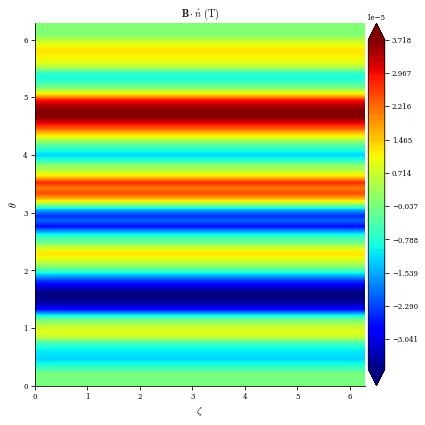

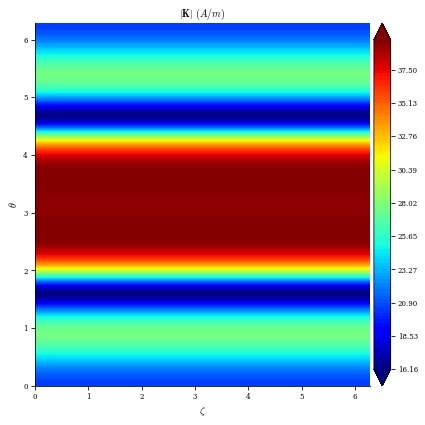

In [40]:
eq3 = eq2.copy()
eq3.surface = FourierCurrentPotentialField.from_surface(eq3.surface, M_Phi=4)


constraints = (
    ForceBalance(eq=eq3),
    FixIota(eq=eq3),
    FixPressure(eq=eq3),
    FixPsi(eq=eq3),
)
objective = ObjectiveFunction(BoundaryError(eq=eq3, field=ext_field, field_fixed=True))
R_modes = eq3.surface.R_basis.modes[np.max(np.abs(eq3.surface.R_basis.modes), 1) > 2, :]
Z_modes = eq3.surface.Z_basis.modes[np.max(np.abs(eq3.surface.Z_basis.modes), 1) > 2, :]
bdry_constraints = (
    FixBoundaryR(eq=eq3, modes=R_modes),
    FixBoundaryZ(eq=eq3, modes=Z_modes),
)
eq3, out = eq3.optimize(
    objective,
    constraints + bdry_constraints,
    optimizer="proximal-lsq-exact",
    verbose=3,
    ftol=1e-4,
    # make the equilibrium solve subproblem ftol a bit lower, as we don't expect big changes in
    # the equilibrium, so we need to resolve the equilibrium more accurately to capture
    # the small changes we will see during this optimization
    options={"solve_options": {"ftol": 1e-4}},
)
VMECIO.plot_vmec_comparison(eq3, "/Users/dpanici/Research/DESC/tests/inputs/wout_solovev_freeb.nc");

desc.plotting.plot_2d(eq3, "B*n", field=ext_field);

desc.plotting.plot_2d(eq3.surface, "K");


# Ok so problem is: Raise beta by 1e4 factor, while still being in free bdry equil (no sheet curr needed idt for now)


In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    SplineMagneticField,
    field_line_integrate,
)
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO
from desc.objectives import GenericObjective
from desc.profiles import ScaledProfile


# need to specify currents in the coil circuits when using mgrid, just like in VMEC
extcur = [
    3.884526409876309e06,
    -2.935577123737952e05,
    -1.734851853677043e04,
    6.002137016973160e04,
    6.002540940490887e04,
    -1.734993103183817e04,
    -2.935531536308510e05,
    -3.560639108717275e05,
    -6.588434719283084e04,
    -1.154387774712987e04,
    -1.153546510755219e04,
    -6.588300858364606e04,
    -3.560589388468855e05,
]
nc_file = "../../tests/inputs/mgrid_solovev.nc"
ext_field = SplineMagneticField.from_mgrid(
    nc_file, extcur=extcur
)
from desc.io import load

eq_freeb_orig = load("orig_freeb_solovev.h5")
eq_target_beta_freeb = load("freeb_at_target_beta.h5")

p = eq_freeb_orig.pressure.copy()

orig_beta = eq_freeb_orig.compute(["<beta>_vol"])["<beta>_vol"]
print(orig_beta)


/home/yigit/Codes/DESC/desc/utils.py:563: UserWarning: mgrid does not appear to contain vector potential information. Vector potential will not be computable.
  warnings.warn(colored(msg, "yellow"), err)


4.189742952971435e-06


In [8]:
obj = ObjectiveFunction(ForceBalance(eq_prox))
obj.build()
obj.dim_x
eq_prox.params_dict

Building objective: force
Precomputing transforms


{'R_lmn': Array([ 4.05351559e+00,  1.05011375e+00, -4.75849069e-02,  5.97434796e-02,
        -2.39443299e-02,  2.05146942e-03, -4.00208491e-03,  5.87484304e-03,
         8.42699488e-04, -2.65821564e-03, -1.70805495e-03,  9.71997765e-05,
        -4.23868371e-04,  7.73661684e-04, -8.15349938e-04, -1.49926405e-05,
        -4.54261406e-04, -3.04058801e-04, -1.73330907e-04,  1.04690337e-05,
         3.79125824e-05,  9.78145573e-05, -3.03306151e-05, -1.90273959e-05,
         1.46354042e-05,  4.15515186e-05, -3.93556627e-05,  7.61311309e-05,
        -1.04690337e-05,  0.00000000e+00, -1.88800996e-05,  1.54251727e-05,
         2.98106503e-06,  3.40200363e-05, -1.46354042e-05,  0.00000000e+00],      dtype=float64),
 'Z_lmn': Array([-1.56027189e+00,  7.82994280e-03, -5.22658097e-03, -2.17766166e-02,
         1.13433885e-04,  3.99762492e-03, -1.06266862e-04,  4.15290032e-03,
        -3.55066115e-03, -4.46716707e-05,  1.24868033e-04,  2.03210522e-03,
        -4.07124479e-06,  2.52204838e-04,  9.825

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
eq_prox = eq_freeb_orig.copy()
eq_prox.pressure = ScaledProfile(1.0, p)
objective = ObjectiveFunction(
    GenericObjective("<beta>_vol",eq_prox,target = 1e3 * orig_beta,name="Vol Avg Beta")
)

constraints = (FixPsi(eq_prox),
               FixIota(eq_prox),
               # only allow pressure scale to change
               FixPressure(eq_prox, indices=list(range(1,eq_prox.pressure.params.size))),
               ForceBalance(eq_prox),
               BoundaryError(eq_prox, ext_field,field_fixed=True))

eq_prox.optimize(objective=objective, constraints=constraints, verbose=3,
                 options={"solve_options":{"ftol":1e-4, "xtol":1e-7},})
                         # "free_boundary_options":{"verbose":3}})


Building objective: Vol Avg Beta
Timer: Objective build = 193 ms
Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 789 ms
Timer: Objective build = 5.73 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.86 sec
Timer: Objective build = 2.02 sec
Timer: Objective build = 4.53 ms
Timer: Eq Update LinearConstraintProjection build = 8.29 sec
Timer: Proximal projection build = 20.2 sec
Timer: Objective build = 3.54 ms
Timer: Free Bdry Eq Update LinearConstraintProjection build = 3.53 sec
Timer: Proximal Free Boundary projection build = 24.5 sec
Building objective: fixed Psi
Building objective: fixed iota
Building objective: fixed pressure
Timer: Objective build = 828 ms
Timer: LinearConstraintProjection build = 2.00 sec


/home/yigit/Codes/DESC/desc/optimize/optimizer.py:558: UserWarning: method lsq-exact function is not intended for scalar objective
  warnings.warn(


Number of parameters: 1
Number of objectives: 1
Timer: Initializing the optimization = 27.5 sec

Starting optimization
Using method: proximal-lsq-exact
not LinearConstraintProjection
dim_x 35


ValueError: Input vector dimension is invalid, expected 132 got 35.

In [ ]:
# the 35 size is the Rb + Zb + p_l + i_l, of the ProximalProjection (why not one more for eq.Psi?)

# the 132 must be the full thing including the R_lmn + Z_lmn + Ra_n + Za)n
96+35 + 1 = 132


# so 

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [6]:
eq_prox.optimizable_params

['R_lmn',
 'Z_lmn',
 'L_lmn',
 'p_l',
 'i_l',
 'c_l',
 'Psi',
 'Te_l',
 'ne_l',
 'Ti_l',
 'Zeff_l',
 'a_lmn',
 'Ra_n',
 'Za_n',
 'Rb_lmn',
 'Zb_lmn',
 'I',
 'G',
 'Phi_mn']

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

import numpy as np
import matplotlib.pyplot as plt

import desc
from desc.magnetic_fields import (
    FourierCurrentPotentialField,
    SplineMagneticField,
    field_line_integrate,
)
from desc.grid import LinearGrid
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium

from desc.objectives import (
    BoundaryError,
    VacuumBoundaryError,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.profiles import PowerSeriesProfile
from desc.vmec import VMECIO
from desc.objectives import GenericObjective
from desc.profiles import ScaledProfile


# need to specify currents in the coil circuits when using mgrid, just like in VMEC
extcur = [
    3.884526409876309e06,
    -2.935577123737952e05,
    -1.734851853677043e04,
    6.002137016973160e04,
    6.002540940490887e04,
    -1.734993103183817e04,
    -2.935531536308510e05,
    -3.560639108717275e05,
    -6.588434719283084e04,
    -1.154387774712987e04,
    -1.153546510755219e04,
    -6.588300858364606e04,
    -3.560589388468855e05,
]
nc_file = "../../tests/inputs/mgrid_solovev.nc"
ext_field = SplineMagneticField.from_mgrid(
    nc_file, extcur=extcur
)
from desc.io import load

eq_freeb_orig = load("orig_freeb_solovev.h5")
eq_target_beta_freeb = load("freeb_at_target_beta.h5")

p = eq_freeb_orig.pressure.copy()

orig_beta = eq_freeb_orig.compute(["<beta>_vol"])["<beta>_vol"]
print(orig_beta)
from desc.objectives import (
    FixCurrent,
    FixIota,
    ObjectiveFunction,
    maybe_add_self_consistency,
)
from desc.objectives.utils import combine_args
from desc.utils import (
    PRINT_WIDTH,
    Timer,
    errorif,
    flatten_list,
    get_instance,
    is_any_instance,
    unique_list,
    warnif,
)
eq_prox = eq_freeb_orig.copy()
eq_prox.pressure = ScaledProfile(1.0, p)
objective = ObjectiveFunction(
    GenericObjective("<beta>_vol",eq_prox,target = 1e3 * orig_beta,name="Vol Avg Beta")
)

constraints = (FixPsi(eq_prox),
               FixIota(eq_prox),
               # only allow pressure scale to change
               FixPressure(eq_prox, indices=list(range(1,eq_prox.pressure.params.size))),
               ForceBalance(eq_prox),
               BoundaryError(eq_prox, ext_field,field_fixed=True))
method_p = "proximal-lsq-exact"
from desc.optimize.optimizer import get_combined_constraint_objectives, _parse_method
# get unique things
things = [eq_prox]
things, indices = unique_list(flatten_list(things, flatten_tuple=True))
counts = np.unique(indices, return_counts=True)[1]
duplicate_idx = np.where(counts > 1)[0]
warnif(
    len(duplicate_idx),
    UserWarning,
    f"{[things[idx] for idx in duplicate_idx]} is duplicated in things.",
)
things0 = [t.copy() for t in things]

# need local import to avoid circular dependencies
from desc.equilibrium import Equilibrium
from desc.objectives import QuadraticFlux

# eq may be None
eq = get_instance(things, Equilibrium)
if eq is not None:
    # save these for later
    eq_params_init = eq.params_dict.copy()
_, method = _parse_method(method_p)

objective, nonlinear_constraint, x_scale = (
            get_combined_constraint_objectives(
                eq,
                constraints,
                objective,
                things,
                "auto",
                method_p,
                method,
                1,
                {},
            )
        )
objective.build()

/home/yigit/Codes/DESC/desc/utils.py:563: UserWarning: mgrid does not appear to contain vector potential information. Vector potential will not be computable.
  warnings.warn(colored(msg, "yellow"), err)


4.189742952971435e-06
Building objective: Vol Avg Beta
Building objective: Boundary error
Precomputing transforms
Building objective: force
Precomputing transforms


AttributeError: 'NoneType' object has no attribute 'jac_unscaled'

In [15]:
print(objective)
print(objective.objectives)
from desc.optimize import ProximalProjection
for obj in objective.objectives:
    if isinstance(obj, ProximalProjection):
        for obji in obj.objectives:
            print(obji.objectives)
    else:
        print(obj.objectives)
        print("OK")


[<desc.objectives.objective_funs.ObjectiveFunction object at 0x734778919eb0>, <desc.optimize._constraint_wrappers.ProximalProjection object at 0x7347c0d4f140>]
(<desc.objectives._generic.GenericObjective object at 0x7347788df050>,)
OK
(<desc.objectives._free_boundary.BoundaryError object at 0x7347847c7410>,)
(<desc.objectives._equilibrium.ForceBalance object at 0x7347783e27b0>,)


In [17]:
objective = ObjectiveFunction(
    BoundaryError(eq_prox, ext_field,field_fixed=True)
    )

constraints = (FixPsi(eq_prox),
               FixIota(eq_prox),
               # only allow pressure scale to change
               FixPressure(eq_prox, indices=list(range(1,eq_prox.pressure.params.size))),
               ForceBalance(eq_prox))
method_p = "proximal-lsq-exact"
from desc.optimize.optimizer import get_combined_constraint_objectives, _parse_method
# get unique things
things = [eq_prox]
things, indices = unique_list(flatten_list(things, flatten_tuple=True))

# need local import to avoid circular dependencies
from desc.equilibrium import Equilibrium
from desc.objectives import QuadraticFlux

# eq may be None
eq = get_instance(things, Equilibrium)
_, method = _parse_method(method_p)

objective, nonlinear_constraint, x_scale = (
            get_combined_constraint_objectives(
                eq,
                constraints,
                objective,
                things,
                "auto",
                method_p,
                method,
                1,
                {},
            )
        )
print(objective)
print(objective.objectives)

Building objective: Boundary error
Precomputing transforms
Building objective: force
Precomputing transforms
Building objective: fixed Psi
Building objective: fixed iota
Building objective: fixed pressure
[<desc.objectives.objective_funs.ObjectiveFunction object at 0x734761f8b110>, <desc.objectives.objective_funs.ObjectiveFunction object at 0x734846925010>]


In [7]:
x_scale

'auto'